Sales forecasting plays an integral role in setting expectations and making plans for your business. It’s your best shot at predicting the future. Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. 

I will be performing an exhaustive analysis in order to gain insights and engineer features with an interactive exploratory analysis and finally will use XGB to predict. 

## Import Dependency

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

import datetime
import math




In [186]:
# define some functions

def ToWeight(y):
    w = np.zeros_like(y, detype)


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y-yhat)**2))
    return rmspe


def rmspe_xg(yhat, dtrain):
    y = dtrain.get_label()  # Extracts the label from DMatrix
    y = np.exp(y) - 1  # Convert back from log scale if necessary
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)  # Use the function above
    rmspe = np.sqrt(np.mean(w * (y-yhat)**2))
    return 'rmspe', rmspe


## Importing Data

In [109]:
train = pd.read_csv('C:/myNotebook/rossmann-store-sales/train.csv')
test = pd.read_csv('rossmann-store-sales/test.csv')
store = pd.read_csv('rossmann-store-sales/store.csv')

train.shape, test.shape, store.shape

((1017209, 9), (41088, 8), (1115, 10))

In [110]:
train.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [111]:
test.head(5)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [112]:
store.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [113]:
# lets check the store in the store and training dataset are the same 
train.Store.nunique() == store.Store.nunique()

True

In [114]:
df = train.merge(store, how = 'left', left_on=train.Store, right_on=store.Store)
df.drop(['key_0','Store_y'], axis=1, inplace=True)
df = df.rename(columns={'Store_x':'Store'})
df.shape

(1017209, 18)

## Uunderstanding the Data

In [115]:
round(df.describe().T, 2)

,count,mean,std,min,25%,50%,75%,max
Store,1017209.0,558.43,321.91,1.0,280.0,558.0,838.0,1115.0
DayOfWeek,1017209.0,4.00,2.00,1.0,2.0,4.0,6.0,7.0
Sales,1017209.0,5773.82,3849.93,0.0,3727.0,5744.0,7856.0,41551.0
Customers,1017209.0,633.15,464.41,0.0,405.0,609.0,837.0,7388.0
Open,1017209.0,0.83,0.38,0.0,1.0,1.0,1.0,1.0
Promo,1017209.0,0.38,0.49,0.0,0.0,0.0,1.0,1.0
SchoolHoliday,1017209.0,0.18,0.38,0.0,0.0,0.0,0.0,1.0
CompetitionDistance,1014567.0,5430.09,7715.32,20.0,710.0,2330.0,6890.0,75860.0
CompetitionOpenSinceMonth,693861.0,7.22,3.21,1.0,4.0,8.0,10.0,12.0
CompetitionOpenSinceYear,693861.0,2008.69,5.99,1900.0,2006.0,2010.0,2013.0,2015.0


there are 1115 stores total; sales average is 5773.82, with 3849.93 volatility, max is 41551.0, need to pay attention to the outlies; average customers is 633.15, with volatility 464.41, max 7388.0, need to pay attentio to the outlineers too. 

In [116]:
train.duplicated().sum(), test.duplicated().sum()

(0, 0)

In [117]:
train.isnull().sum(), test.isnull().sum()

(Store            0
 DayOfWeek        0
 Date             0
 Sales            0
 Customers        0
 Open             0
 Promo            0
 StateHoliday     0
 SchoolHoliday    0
 dtype: int64,
 Id                0
 Store             0
 DayOfWeek         0
 Date              0
 Open             11
 Promo             0
 StateHoliday      0
 SchoolHoliday     0
 dtype: int64)

There are no duplicates and Testing dataset has 11 null values in Open.


In [118]:
print('Training date start from: {}'.format(train.Date.min()))
print('Training date end on: {}'.format(train.Date.max()))
print()
print('Testing date start from: {}'.format(test.Date.min()))
print('Testing date end on: {}'.format(test.Date.max()))

Training date start from: 2013-01-01
Training date end on: 2015-07-31

Testing date start from: 2015-08-01
Testing date end on: 2015-09-17


In [119]:
print(f'Training date start from :{train.Date.min()} ')

Training date start from :2013-01-01 


## Exploratory Data Analysis

In [120]:
df.Date = pd.to_datetime(df.Date)
df['Day'] = df.Date.dt.day
df['Month'] = df.Date.dt.month
df['Year'] = df.Date.dt.year
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Day,Month,Year
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,1270.0,9.0,2008.0,0,NaN,NaN,NaN,31,7,2015
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",31,7,2015
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",31,7,2015
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,620.0,9.0,2009.0,0,NaN,NaN,NaN,31,7,2015
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,29910.0,4.0,2015.0,0,NaN,NaN,NaN,31,7,2015


I wish to explore seasonality and trend in the dateset and somehow engineer and pre_process features with the analysis I perform.

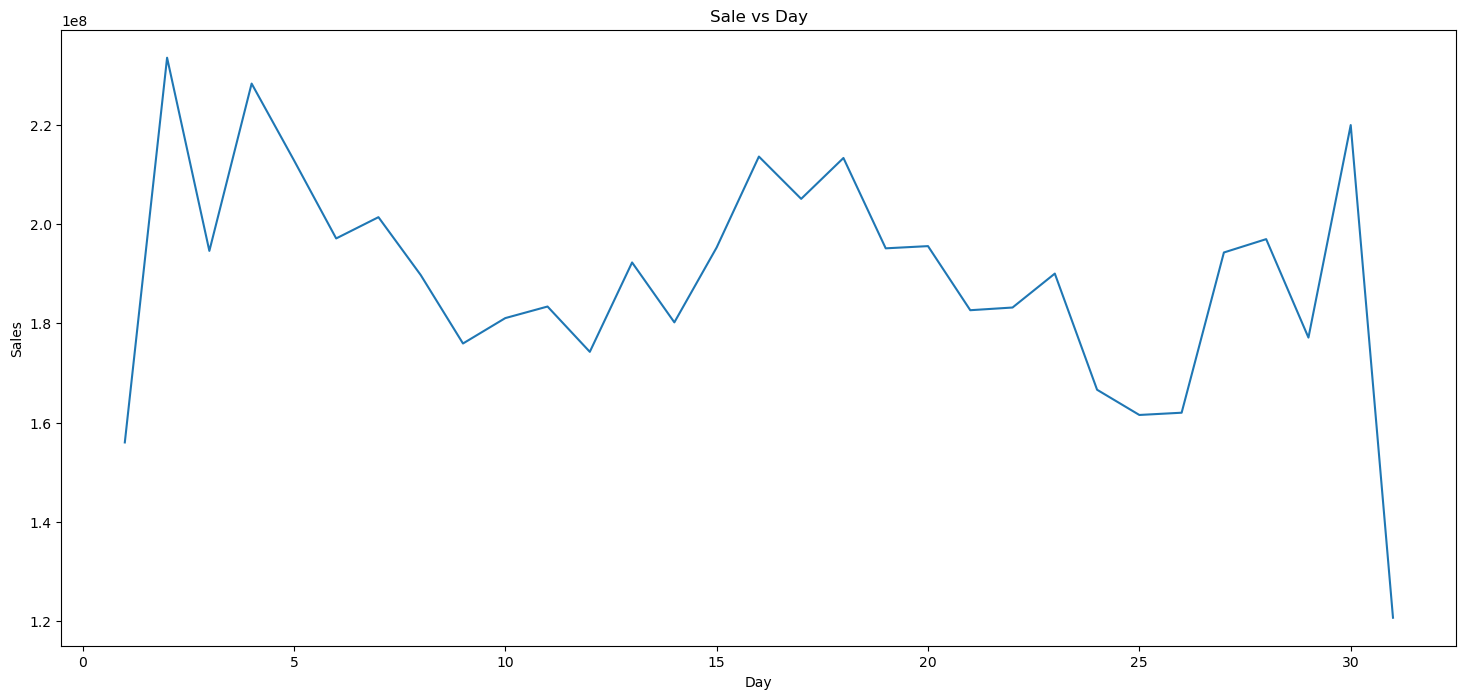

In [121]:
plt.figure(figsize=(18,8))
plt.plot(df.groupby(df.Day)['Sales'].sum())
plt.title("Sale vs Day")
plt.xlabel('Day')
plt.ylabel('Sales')
plt.show()

most of the sales happens at the begining of the month, a little small pike at after 15th, it might related to the paycheck schecule with people

Text(0, 0.5, 'Sale')

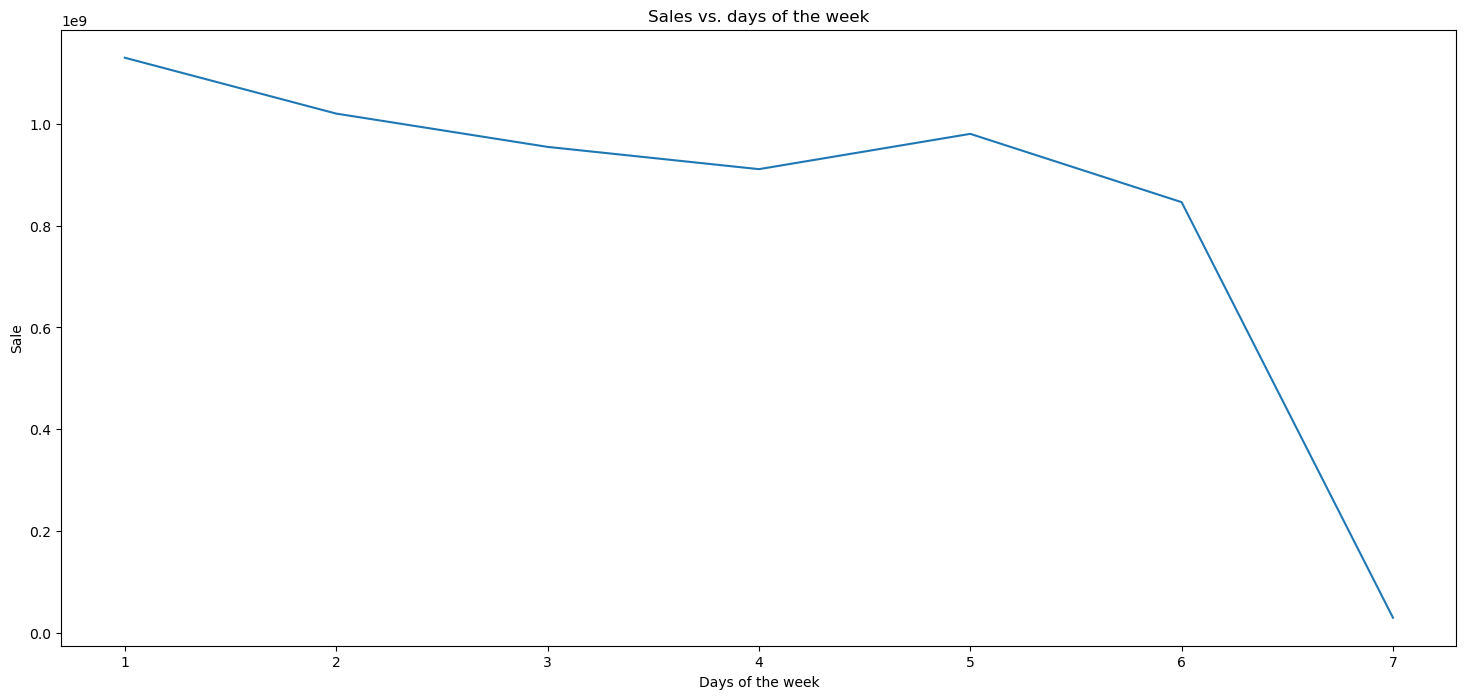

In [122]:
plt.figure(figsize=(18,8))
plt.plot(df.groupby(df.DayOfWeek)['Sales'].sum())
plt.title('Sales vs. days of the week')
plt.xlabel('Days of the week')
plt.ylabel('Sale')

Sales are more at the begining of the week, no sale on sundays, maybe they are not onpen on sundays。



Text(0, 0.5, 'sales')

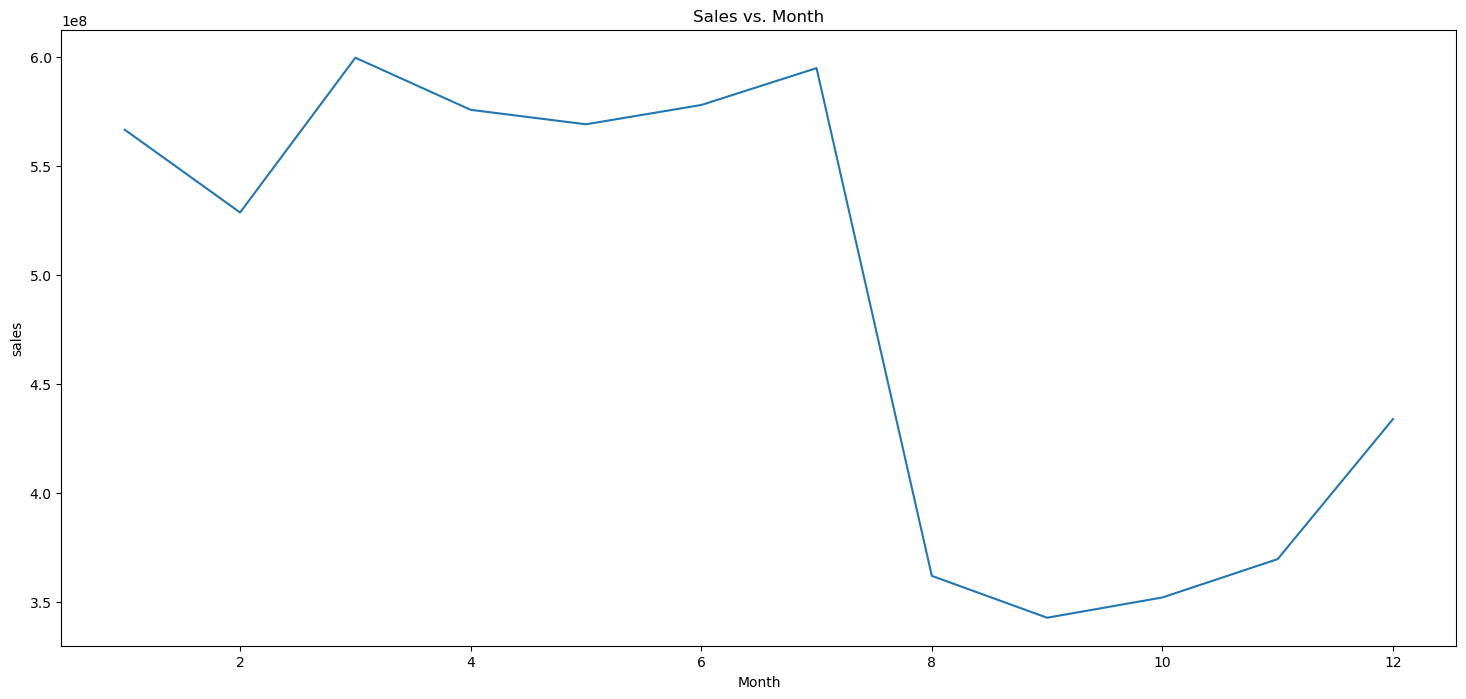

In [123]:
plt.figure(figsize=(18,8))
plt.plot(df.groupby(df.Month)['Sales'].sum())
plt.title('Sales vs. Month')
plt.xlabel('Month')
plt.ylabel('sales')

It looks sales mostly heppens before August.? 2015 year, only have data until August, maybe thats why. Thats plot the sales for daily.

Text(0, 0.5, 'Sales')

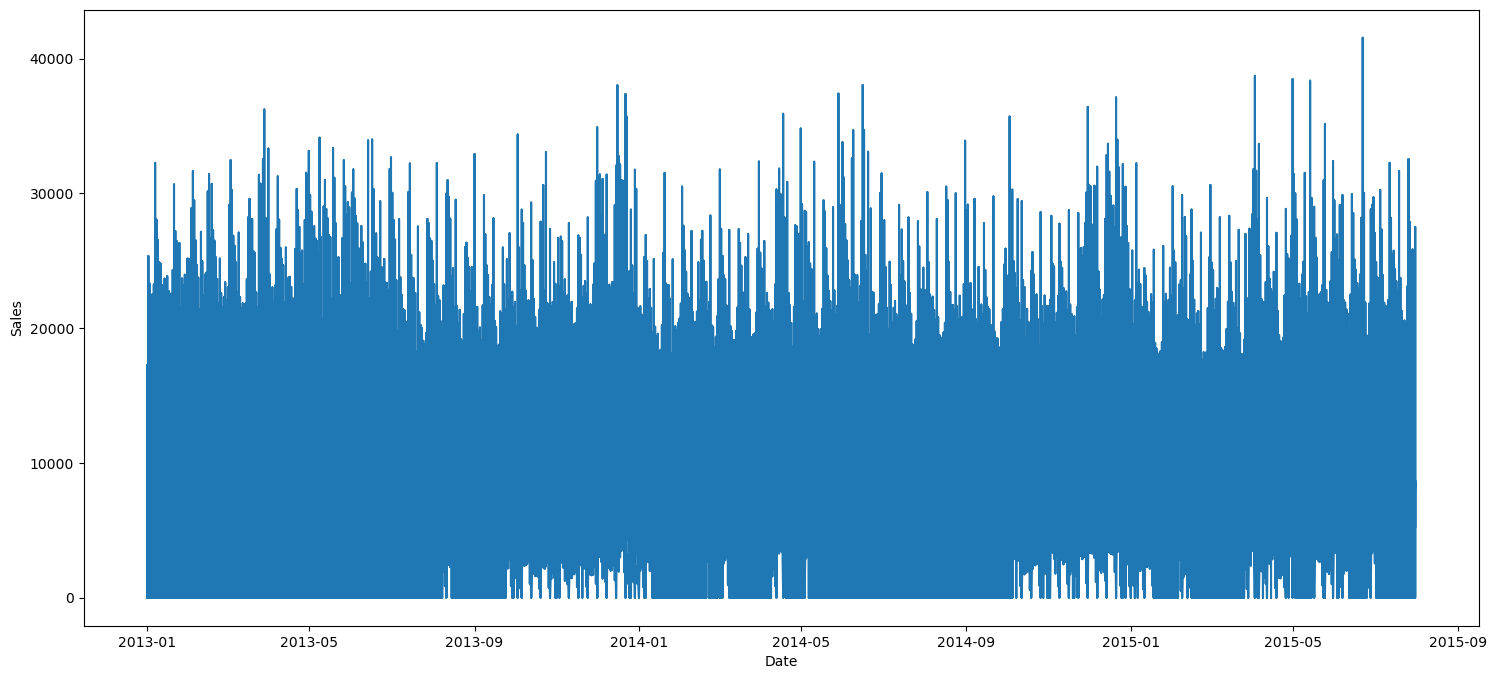

In [124]:
plt.figure(figsize=(18,8))
plt.plot(df.Date, df['Sales'])
plt.xlabel('Date')
plt.ylabel('Sales')


Text(0, 0.5, 'Sales')

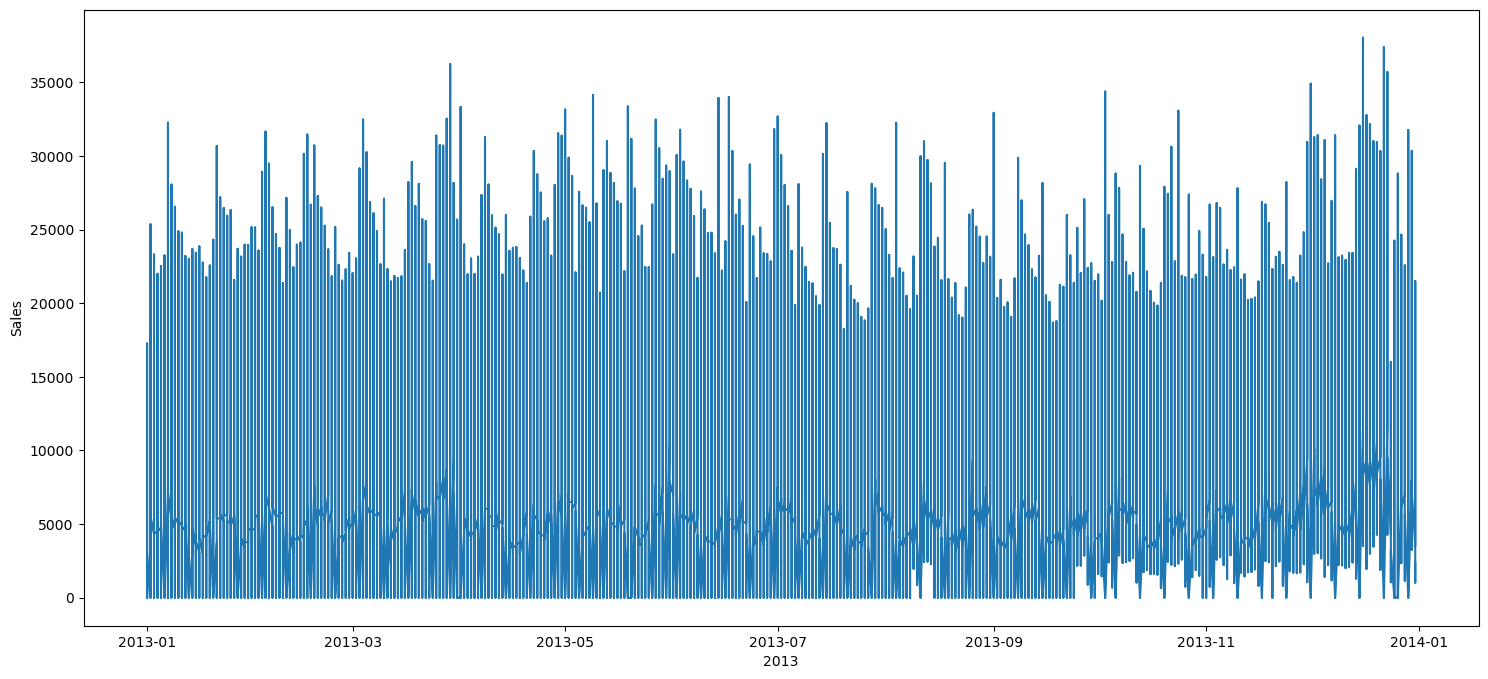

In [125]:
data_2013 = df[df['Year'] == 2013]
data_2013.set_index('Date', inplace = True)
plt.figure(figsize=(18,8))
plt.plot(data_2013['Sales'])
plt.xlabel('2013')
plt.ylabel('Sales')

Text(0, 0.5, 'Sales')

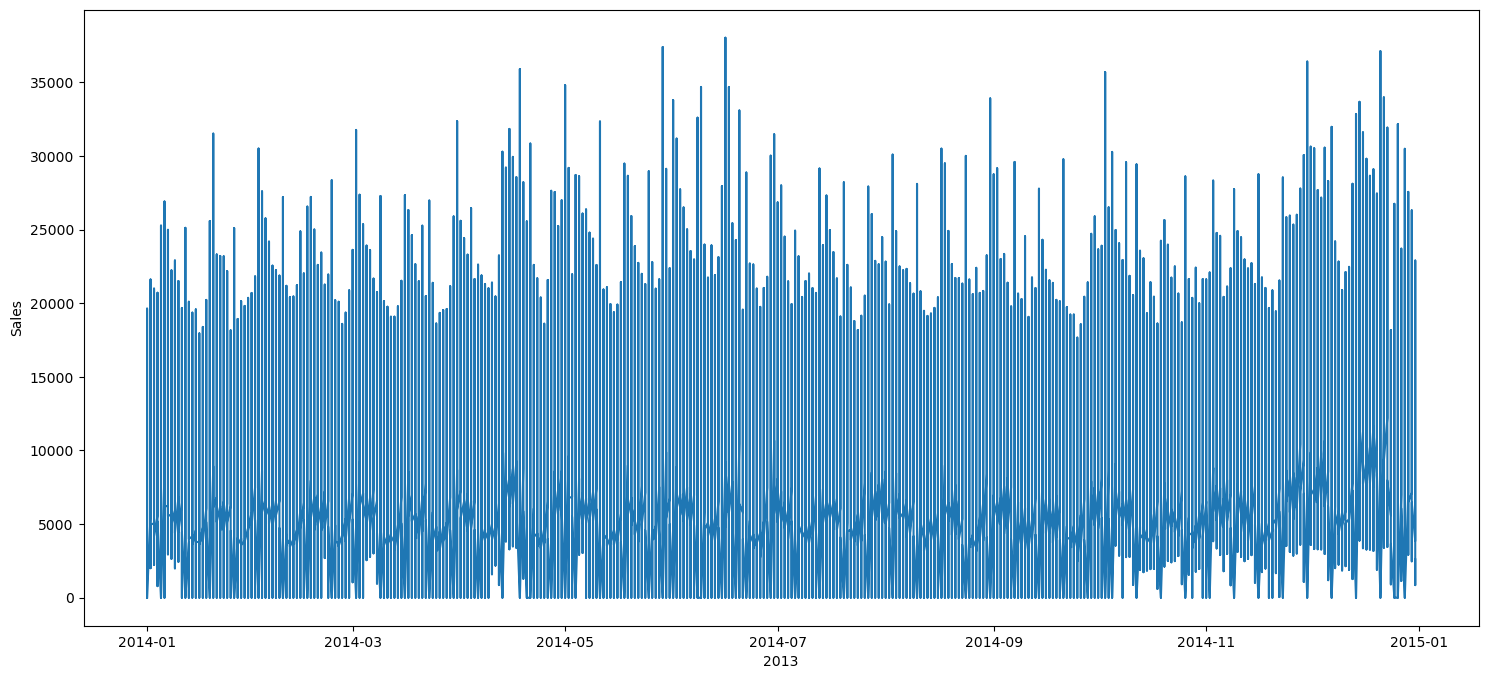

In [126]:
data_2014 = df[df['Year'] == 2014]
data_2014.set_index('Date', inplace = True)
plt.figure(figsize=(18,8))
plt.plot(data_2014['Sales'])
plt.xlabel('2013')
plt.ylabel('Sales')


Text(0, 0.5, 'Sales')

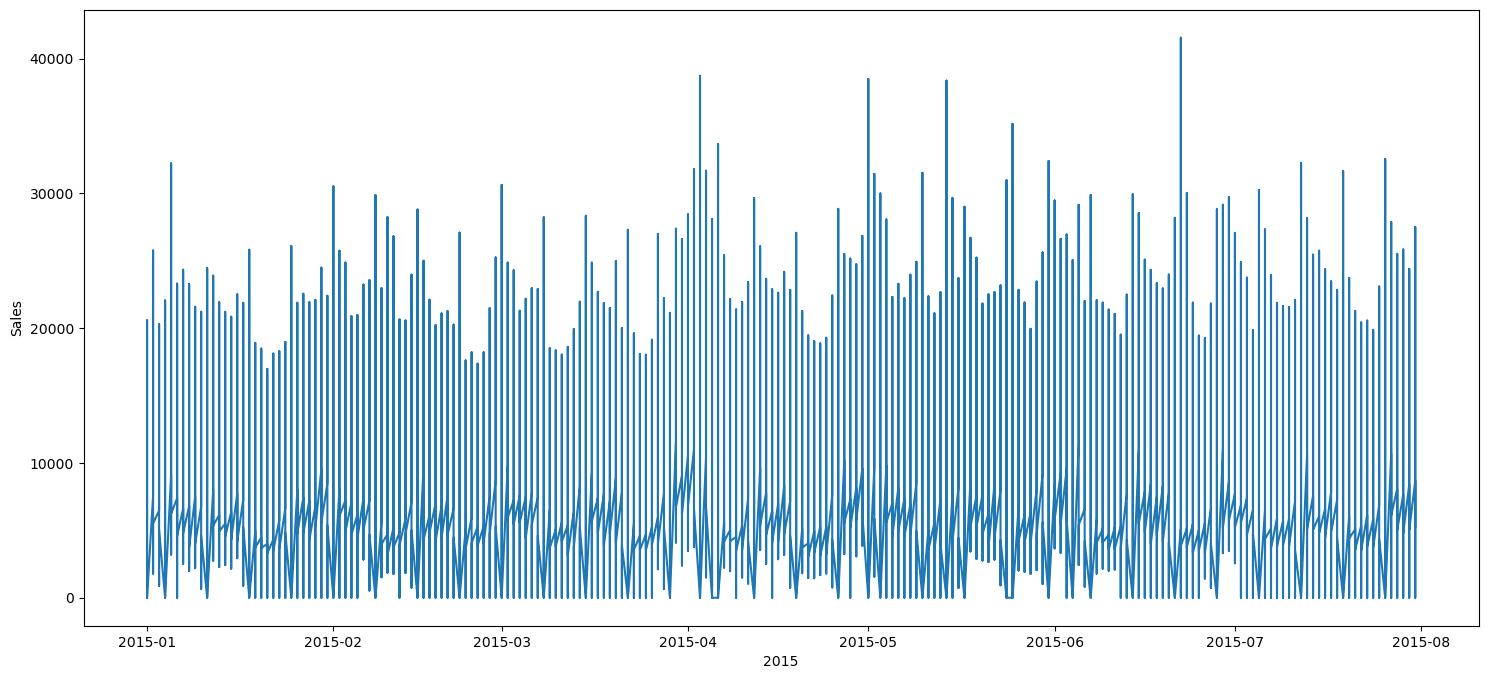

In [127]:
data_2015 = df[df['Year'] == 2015]
data_2015.set_index('Date', inplace = True)
plt.figure(figsize=(18,8))
plt.plot(data_2015['Sales'])
plt.xlabel('2015')
plt.ylabel('Sales')

Sales Daily is pretty consistant, only 2015 sales, only have record untIL August.


<Axes: xlabel='Sales', ylabel='Density'>

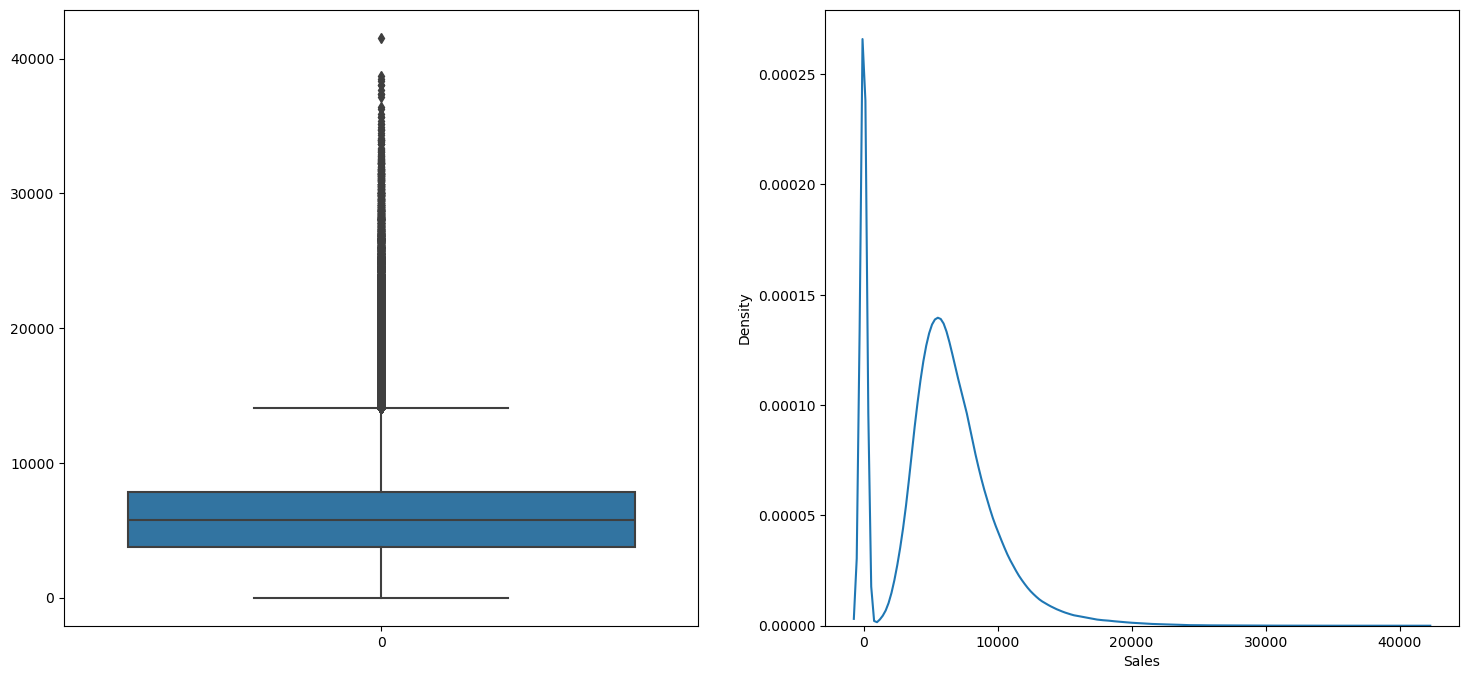

In [128]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
sns.boxplot(train.Sales, ax=ax1)
sns.kdeplot(train.Sales, ax=ax2)

There is huge amount of days have sales 0, this means it either to fill gaps.  It also could means the store is colsed, maybe there was a holidays.

In [129]:
df[df.Open == 0].Sales.value_counts()

Sales
0    172817
Name: count, dtype: int64

Its correct, there are 172817 values are filled with 0, I will fill those values with np.NaN as some models like XgBoost can handle missing values and it might benifit from it.


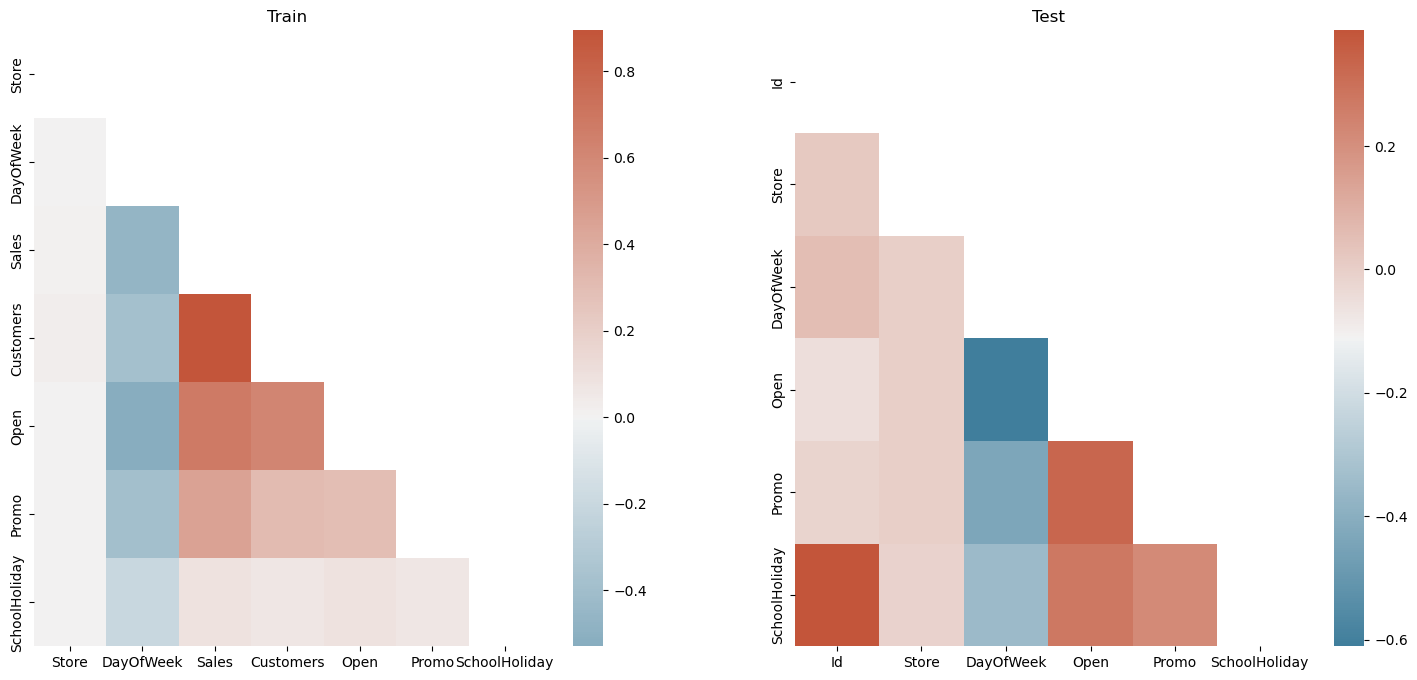

In [130]:


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Train heatmap
corr_train = train.select_dtypes(include=[np.number]).corr()
mask_train = np.triu(np.ones_like(corr_train, dtype=bool))
sns.heatmap(corr_train, mask=mask_train, cmap=cmap, center=0, annot=True, ax=ax1)
ax1.set_title('Train')

# Test heatmap
corr_test = test.select_dtypes(include=[np.number]).corr()
mask_test = np.triu(np.ones_like(corr_test, dtype=bool))
sns.heatmap(corr_test, mask=mask_test, cmap=cmap, annot=True, ax=ax2)
ax2.set_title('Test')

plt.show()



Sales are highly correlated with feature customers and open, moderately correclated with Promo.

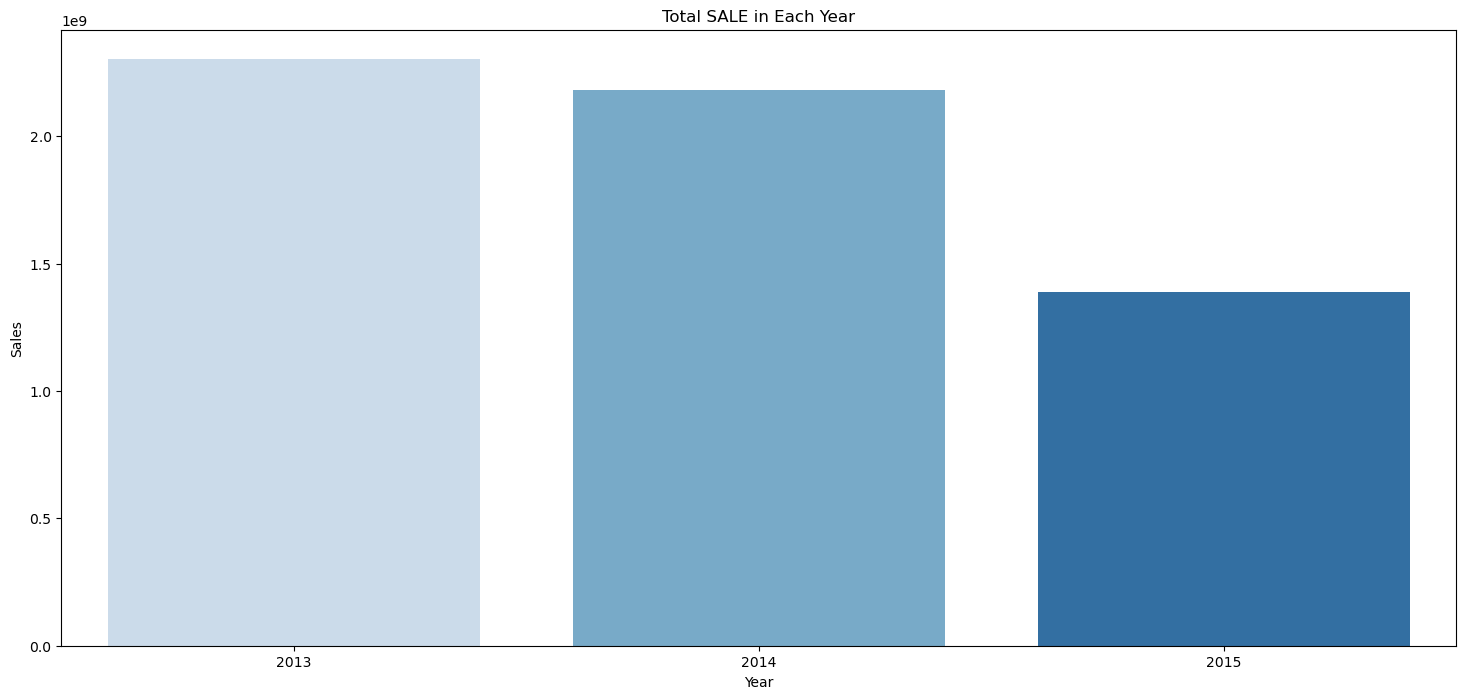

In [131]:
plt.figure(figsize=(18,8))
df.Date = pd.to_datetime(df.Date)
df['Day'] = df.Date.dt.day
df['Month'] = df.Date.dt.month
df['Year'] = df.Date.dt.year
temp_df = df.groupby('Year').agg({'Sales': 'sum'})
sns.barplot(x=temp_df.index, y=temp_df.Sales, palette='Blues')
plt.title("Total SALE in Each Year")
plt.xlabel('Year')
plt.ylabel('Sales')
plt.show()

Pay attention to the sales, 2015 only have 8 months record， so this correlation might dont have any significance.


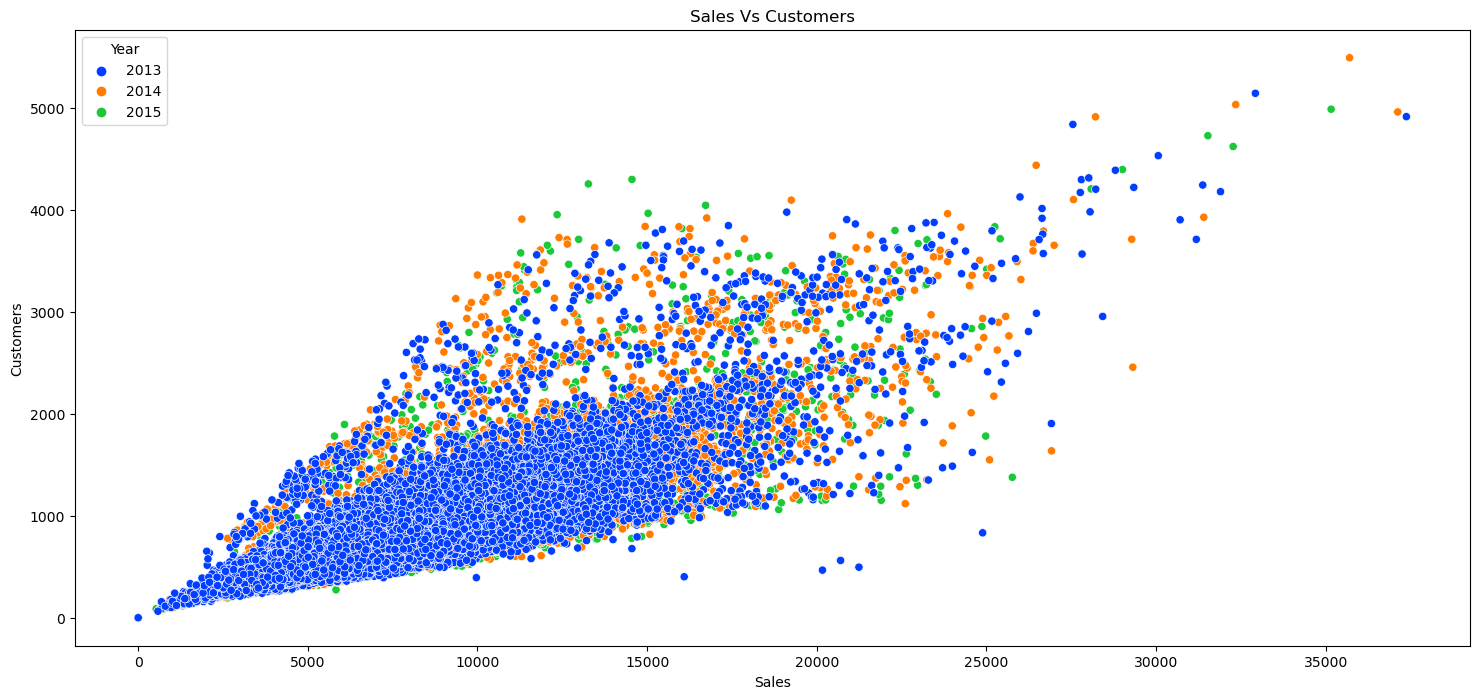

In [132]:
plt.figure(figsize=(18,8))
temp_df = df.sample(100000)
sns.scatterplot(x=temp_df.Sales,y=temp_df.Customers, hue=df.Year,palette='bright')
plt.title("Sales Vs Customers")
plt.show()

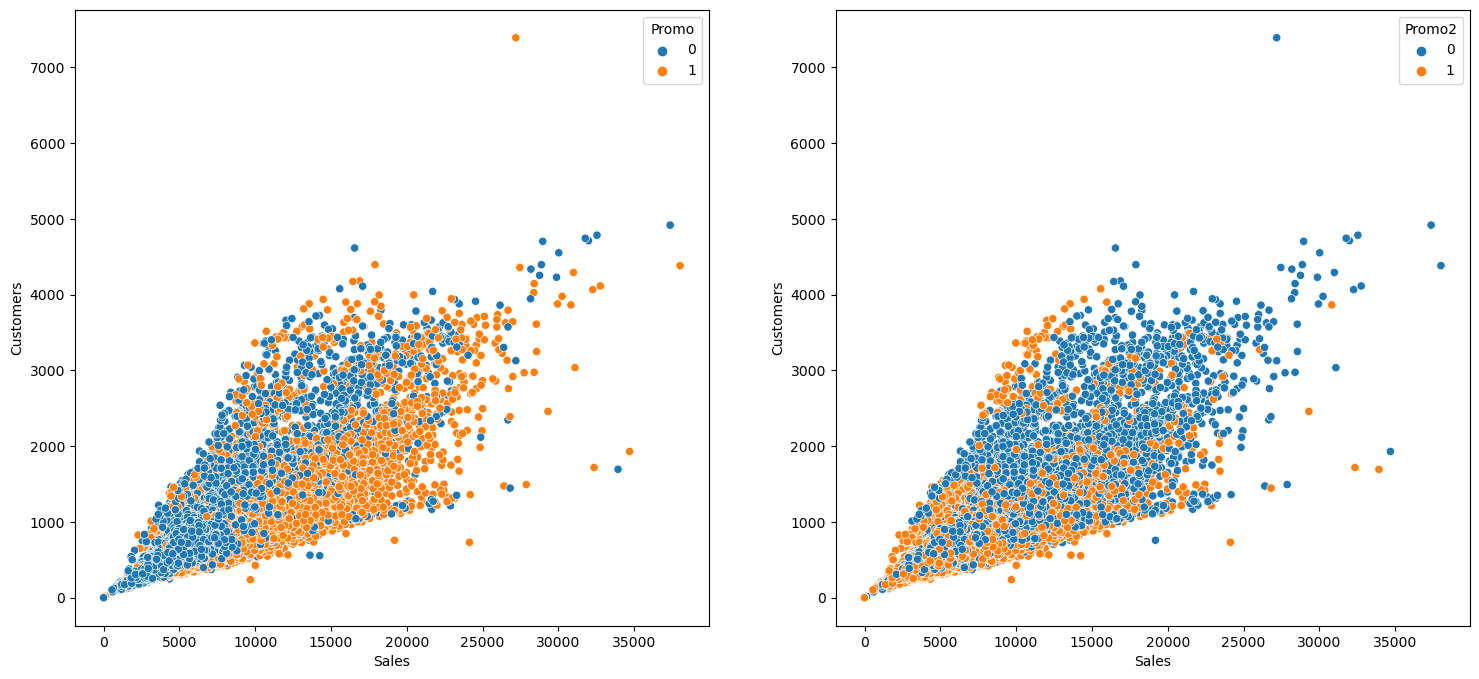

In [133]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
temp_df = df.sample(100000)
sns.scatterplot(x=temp_df.Sales, y=temp_df.Customers, hue=df.Promo, ax=ax1)
sns.scatterplot(x=temp_df.Sales, y=temp_df.Customers, hue=df.Promo2, ax=ax2)
plt.show()

from the color seperation style, Promo is more related to the Sales than Promo2

In [134]:
# check the total sale of these two promo
df.groupby(df.Promo)['Sales'].mean()[1] > df.groupby(df.Promo2)['Sales'].mean()[1]
#[1]means store participated

True

Lets see if the type of store is a significanet feature!
Stores inventort and ambience should be a huge factor.

Text(0, 0.5, 'Sales')

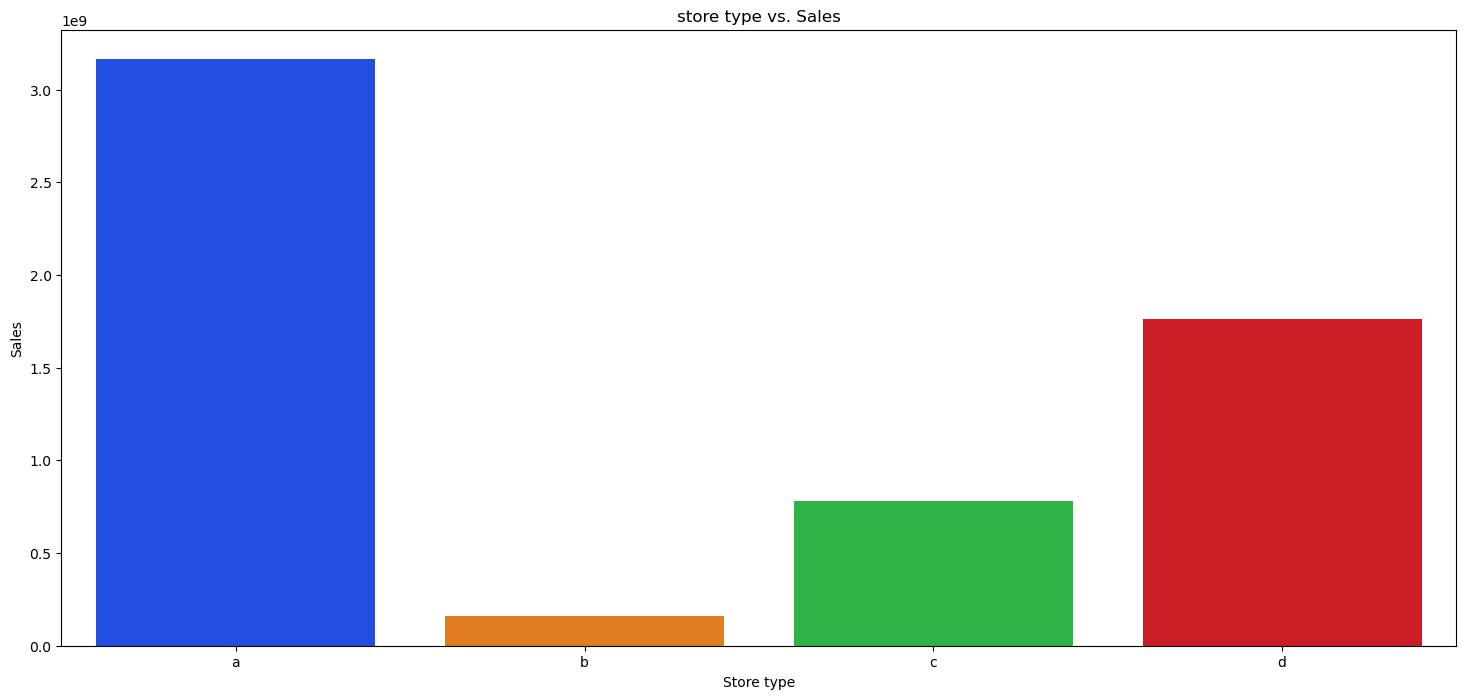

In [135]:
plt.figure(figsize=(18,8))
temp_df = df.groupby(df.StoreType).agg({'Sales': 'sum'})
sns.barplot(x=temp_df.index, y=temp_df.Sales, palette='bright')
plt.title('store type vs. Sales')
plt.xlabel('Store type')
plt.ylabel('Sales')

Why store A outperfrom all the other stores? Do they do more promo1? what about the competition distance?



<Axes: xlabel='StoreType', ylabel='CompetitionDistance'>

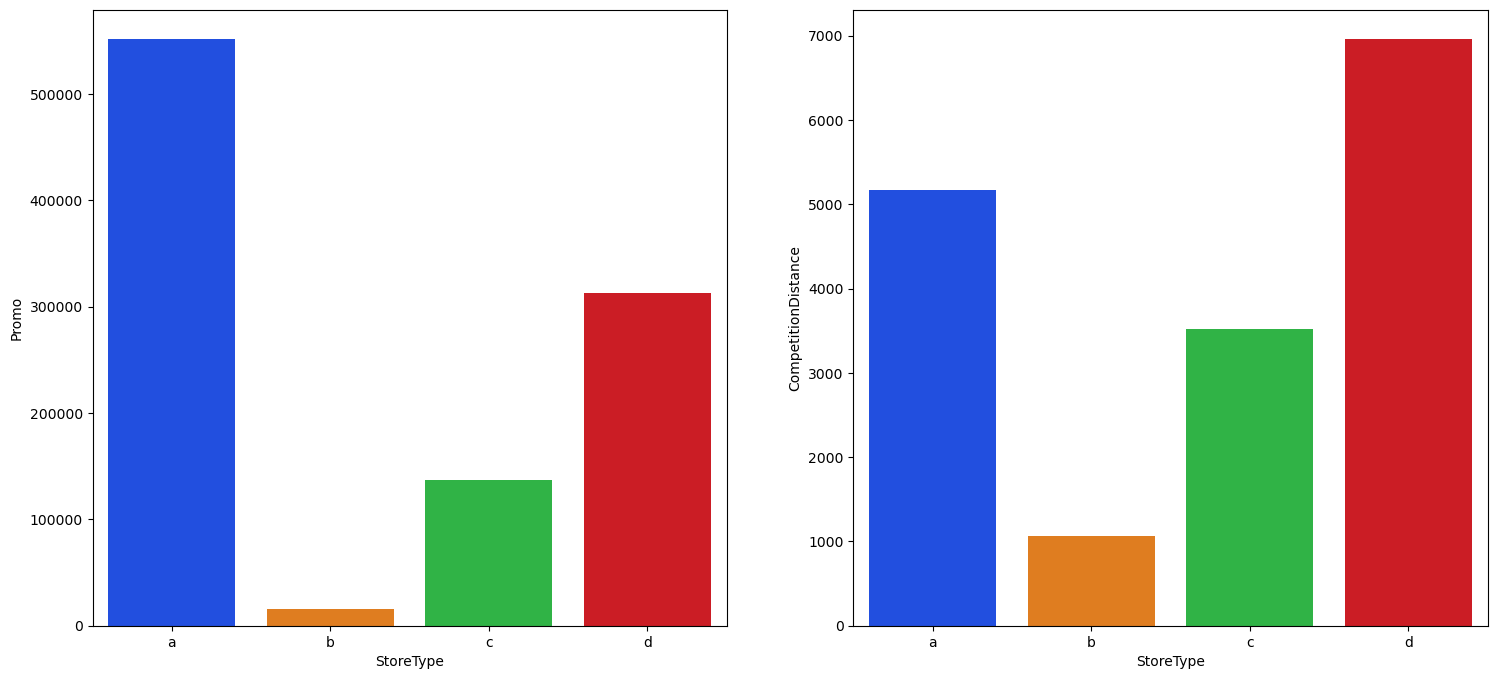

In [136]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
temp_df = df.groupby(df.StoreType).count()
# check if the promo play a role 
sns.barplot(x=temp_df.index, y=temp_df['Promo'],ax=ax1, palette='bright' )
# check the competition distance
temp_df = df.groupby(df.StoreType).agg({'CompetitionDistance':'mean'})
sns.barplot(x=temp_df.index, y= temp_df['CompetitionDistance'], ax=ax2, palette= 'bright')



Store A dose have the most Promo, even though it has the second competition distance.
Store D has the second sales, it has the second count promo, the most far away from competition distance. 
Thus, the Promo is a big deal to the sales, other feature could be the seaonality, trend.
Lets check the time series factors on sales

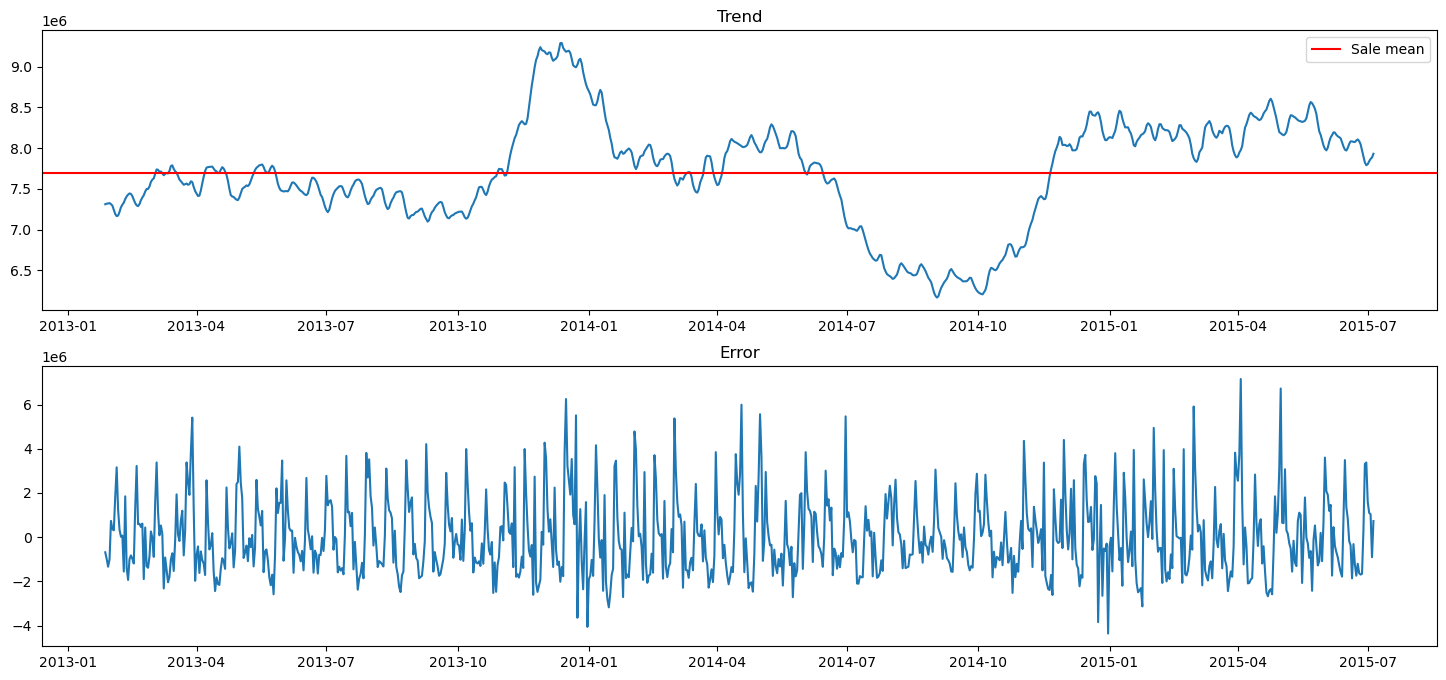

In [137]:
from statsmodels.tsa.seasonal import seasonal_decompose
temp_df = train.copy()
temp_df.Date = pd.to_datetime(temp_df.Date)
temp_df.index = temp_df.Date
temp_df.Sales = temp_df.Sales.apply(lambda x: None if x==0 else x)
temp_df.Sales = temp_df.Sales.fillna(method='ffill').fillna(method='bfill')
temp_df = temp_df[['Sales']]
temp_df = temp_df.groupby(temp_df.index).agg({'Sales':'sum'})
result = seasonal_decompose(temp_df, model='additive',period=52)

#plot the sales with time out
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18, 8))
ax1.plot(result.trend)
ax1.axhline(y=temp_df.Sales.mean(), color='r', linestyle='-', label='Sale mean')
ax1.set_title('Trend')

ax2.plot(result.resid)
ax2.set_title('Error')
ax1.legend()


2015 is a good year as the trend line is above the averafe line by the end of 2014. since 2014, the sales not that good, the that related to competition?

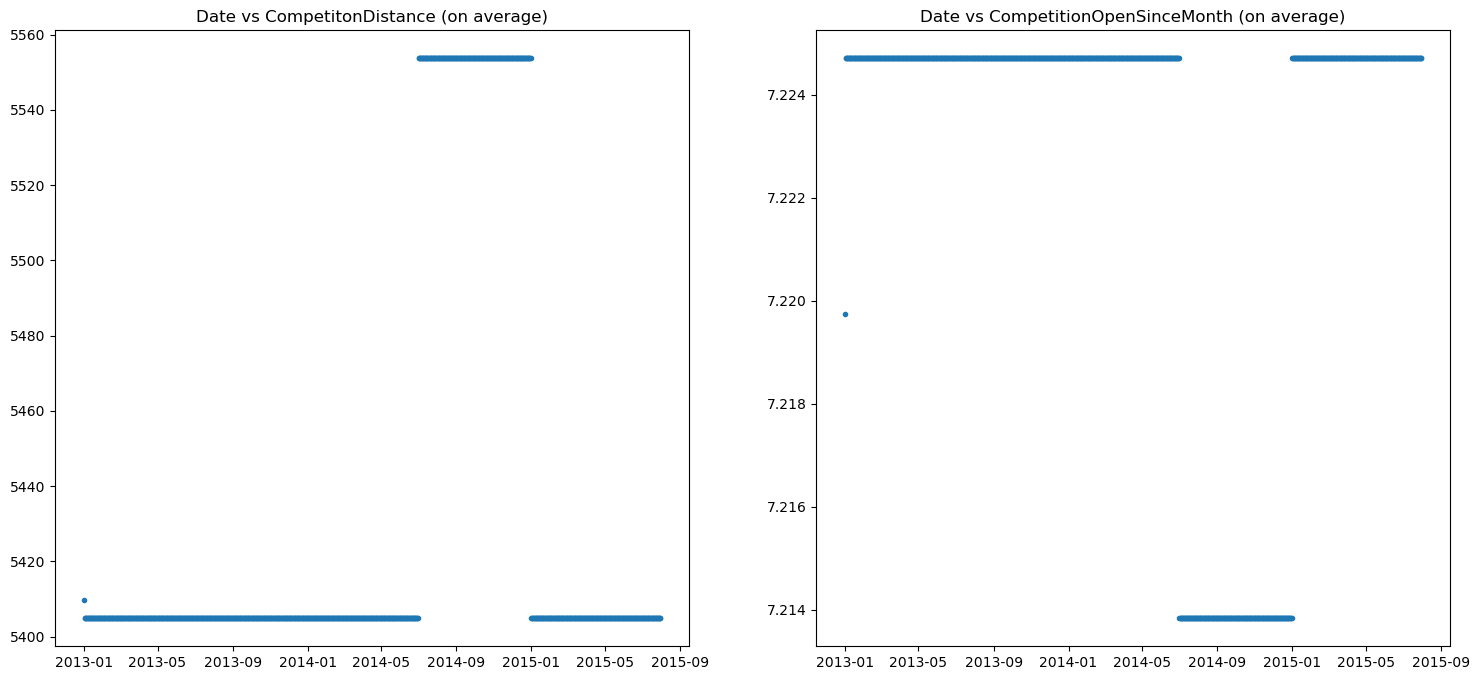

In [138]:
temp_df = df.copy()
temp_df.index = temp_df.Date
temp_df.Sales = temp_df.Sales.apply(lambda x: None if x == 0 else x)
temp_df.Sales = temp_df.Sales.fillna(method='ffill').fillna(method='bfill')
temp_df = temp_df.groupby(temp_df.index).agg({'CompetitionDistance':'mean', 'CompetitionOpenSinceMonth':'mean'})

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
ax1.plot(temp_df.CompetitionDistance, '.')
ax1.set_title("Date vs CompetitonDistance (on average)")
ax2.plot(temp_df.CompetitionOpenSinceMonth, '.')
ax2.set_title("Date vs CompetitionOpenSinceMonth (on average)")
plt.show()





It seems the competitor near the end of 2014. the distance relatively increased.
It could be useful for the model to interpret such behavior in the future for the store.




In [139]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Day,Month,Year
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,1270.0,9.0,2008.0,0,NaN,NaN,NaN,31,7,2015
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",31,7,2015
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",31,7,2015
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,620.0,9.0,2009.0,0,NaN,NaN,NaN,31,7,2015
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,29910.0,4.0,2015.0,0,NaN,NaN,NaN,31,7,2015


In [140]:
#check the promo in 2014

temp_df = df.copy()
temp_df.index = temp_df.Date
temp_df = temp_df[temp_df.Year==2014]

temp_df.Sales = temp_df.Sales.apply(lambda x: None if x == 0 else x)
temp_df.Sales = temp_df.Sales.fillna(method='ffill').fillna(method='bfill')
print(temp_df.describe().T)





                              count                           mean  \
Store                      373855.0                     559.170379   
DayOfWeek                  373855.0                       3.998462   
Date                         373855  2014-06-23 23:34:53.191210496   
Sales                      373855.0                    7228.223983   
Customers                  373855.0                     643.268034   
Open                       373855.0                       0.830314   
Promo                      373855.0                       0.381913   
SchoolHoliday              373855.0                       0.186201   
CompetitionDistance        372944.0                    5473.399465   
CompetitionOpenSinceMonth  254765.0                       7.219712   
CompetitionOpenSinceYear   254765.0                    2008.727074   
Promo2                     373855.0                       0.480697   
Promo2SinceWeek            179711.0                      22.670783   
Promo2SinceYear     

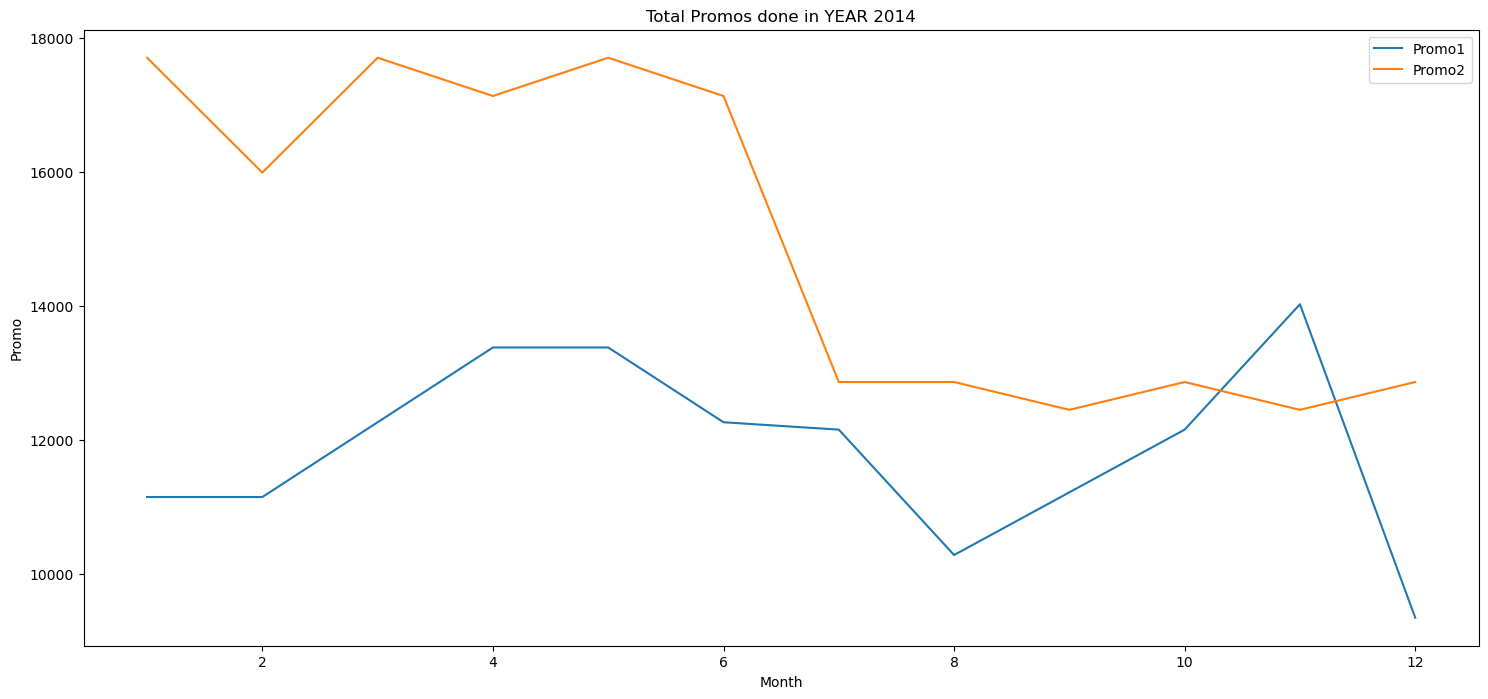

In [141]:
plt.figure(figsize=(18,8))
temp_df = df.copy()
temp_df.index = temp_df.Date
temp_df = temp_df[temp_df.Year==2014]
temp_df = temp_df.groupby(temp_df.Month).agg({'Sales': 'sum', 'Promo': 'sum', 'Promo2': 'sum'})
temp_df.Sales = temp_df.Sales.apply(lambda x: None if x == 0 else x)
temp_df.Sales = temp_df.Sales.fillna(method='ffill').fillna(method='bfill')

plt.title('Total Promos done in YEAR 2014')
sns.lineplot(data=temp_df, x=temp_df.index, y='Promo', palette='Blues', label='Promo1')
sns.lineplot(data=temp_df, x=temp_df.index, y='Promo2', palette='Blues', label='Promo2')
plt.legend()
plt.show()


## Feature Engineering and Preprocessing

In [142]:
features_x = ['Store', 'Date','DayOfWeek','Open','Promo','SchoolHoliday','StateHoliday']
features_y = ['SalesLog']

In [143]:
train['is_train'] = 1
test['is_train'] = 0
df = pd.concat([train, test])

In [144]:
# convert date to required format
df.Date = pd.to_datetime(df.Date)

In [145]:
# remove rows with sale 0
df = df.loc[~((df['Open']==1)&(df['Sales']==0))]

In [146]:
unique_values = df['StateHoliday'].unique()
print(unique_values)

['0' 'a' 'b' 'c' 0]


In [147]:

df.StateHoliday = df.StateHoliday.map({0:'0', 'a':'a', 'b':'b', 'c':'c','0':'0'})
df.StateHoliday = LabelEncoder().fit_transform(df.StateHoliday)




In [148]:
# add time features
var_name = 'Date'

df[var_name + 'Day'] = df[var_name].dt.day
df[var_name + 'DayOfWeek'] = df[var_name].dt.dayofweek
df[var_name + 'Month'] = df[var_name].dt.month
df[var_name + 'Year'] = df[var_name].dt.year
df[var_name + 'DayOfYear'] = df[var_name].dt.dayofyear

features_x.remove(var_name)
features_x.append(var_name + 'Day')
features_x.append(var_name + 'DayOfWeek')
features_x.append(var_name + 'Month')
features_x.append(var_name + 'Year')
features_x.append(var_name + 'DayOfYear')




In [149]:
#encode store type
store.StoreType = LabelEncoder().fit_transform(store.StoreType)
store.Assortment = LabelEncoder().fit_transform(store.Assortment)

In [150]:
join_with = store['PromoInterval'].str.split(',').apply(pd.Series)
join_with.columns = join_with.columns.map(lambda x: str(x) + '_PromoInterval')
store = store.join(join_with)

In [151]:
import calendar

def monthToNum(value):
    # Correct the abbreviation for September
    if value == 'Sept':
        value = 'Sep'
    
    # Convert month_abbr to a list and find the index
    months = list(calendar.month_abbr)  # Convert month_abbr to a list
    try:
        return months.index(value)  # Now you can use index
    except ValueError:
        return None  
    
store['0_PromoInterval'] = store['0_PromoInterval'].map(lambda x:monthToNum(x) if str(x) != 'nan' else np.nan)
store['1_PromoInterval'] = store['1_PromoInterval'].map(lambda x:monthToNum(x) if str(x) != 'nan' else np.nan)
store['2_PromoInterval'] = store['2_PromoInterval'].map(lambda x:monthToNum(x) if str(x) != 'nan' else np.nan)
store['3_PromoInterval'] = store['3_PromoInterval'].map(lambda x:monthToNum(x) if str(x) != 'nan' else np.nan)


In [152]:
competition_open = []
for index, value in store[['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']].iterrows():
    try:
        year, month = int(value['CompetitionOpenSinceYear']), int(value['CompetitionOpenSinceMonth'])
        date = pd.to_datetime("{}-{}-01".format(year, month), format='%Y-%m')
        competition_open.append(date)
    except:
        competition_open.append(np.nan)
competition_open = pd.Series(competition_open)
competition_open.shape

(1115,)

In [153]:
store['CompetitionOpen'] = pd.to_datetime(competition_open)
store['CompetitionOpen'] = store.CompetitionOpen.dt.strftime('%Y%m%d')

In [195]:
promo = []
for index, value in store[['Promo2SinceWeek','Promo2SinceYear']].iterrows():
    try:
        year,week = int(value['Promo2SinceYear']),int(value['Promo2SinceWeek'])
        date = pd.to_datetime({'{}-{}-01'}.format(year, week), format='%Y-%W')
        promo.append(date)
    except:
        promo.append(np.nan)
        
promo = pd.to_datetime(pd.Series(promo))
promo.shape
    

(1115,)

In [155]:
store['PromoSince'] = promo
store['PromoSince'] = store.PromoSince.dt.strftime('%Y%m%d')

In [156]:
store_features = ['Store', 'StoreType','Assortment','CompetitionOpen','CompetitionDistance',
                  'PromoSince','0_PromoInterval']

In [157]:
df = pd.merge(df, store[store_features], how='left', on=['Store'])

In [158]:
features_x = list(set(features_x + store_features))

In [205]:
for feature in features_x:
    df[feature] = df[feature].fillna(-999) 

In [160]:
df['DateInt'] = df.Date.dt.strftime('%Y%m%d').map(int)
df['CompetitonOpen'] = df.CompetitionOpen.map(int)
df['PromoSince'] = df.PromoSince.map(int)

In [161]:
df['Zscore'] = (df.Sales - df.Sales.mean())/df['Sales'].std()

In [162]:
thresh = 4.0
def check_outlier(value):
    if value >= thresh:
        return True
    else:
        return False
df['Outlier'] = df.Zscore.apply(check_outlier)

In [163]:
store_data_sales = df.groupby([df['Store']])['Sales'].sum()
store_data_customers = df.groupby([df['Store']])['Customers'].sum()
store_data_open = df.groupby([df['Store']])['Open'].count()

store_data_sales_per_day = store_data_sales/store_data_open
store_data_customers_per_day = store_data_customers/store_data_open
store_data_sales_per_customer_per_day = store_data_sales_per_day/store_data_customers_per_day

df_store = pd.merge(store, store_data_sales_per_day.reset_index(name='SalesPerDay'), how='left', on=['Store'])
df_store = pd.merge(df_store, store_data_customers_per_day.reset_index(name='CustomersPerDay'), how='left', on=['Store'])
df_store = pd.merge(df_store, store_data_sales_per_customer_per_day.reset_index(name='SalesPerCustomersPerDay'),how='left',on=['Store'])

In [197]:
store_features = ['Store','SalesPerDay','CustomersPerDay','SalesPerCustomersPerDay']

features_x = list(set(features_x + store_features))
df = pd.merge(df, df_store[store_features], how='left', on=['Store'])

In [165]:
holidays_each_day_of_week = df.groupby(df.DayOfWeek).agg({'StateHoliday':'sum'}).StateHoliday
df = pd.merge(df, holidays_each_day_of_week.reset_index(name='HolidaysPerDayOfWeek'), on=['DayOfWeek'])

In [166]:
school_holidays_each_day_of_week = df.groupby(df.DayOfWeek).agg({'SchoolHoliday':'sum'}).SchoolHoliday
df = pd.merge(df, holidays_each_day_of_week.reset_index(name='SchoolHolidaysPerDayOfWeek'), on=['DayOfWeek'])

In [167]:
promo_each_days_of_week = df.groupby(df.DayOfWeek).agg({'Promo':'sum'}).Promo
df = pd.merge(df, promo_each_days_of_week.reset_index(name='PromoPerDayOfWeek'), on=['DayOfWeek'])

In [168]:
holidays_this_week=[]
index_list = []
for index, value in df.groupby(df.Date).sum().iterrows():
    start_range = index 
    end_range = index + datetime.timedelta(days=7)
    school_holidays = sum((df.groupby(df.Date).sum()[start_range:end_range]).SchoolHoliday)
    state_holidays = sum((df.groupby(df.Date).sum()[start_range:end_range]).StateHoliday)
    holidays_this_week.append(school_holidays+state_holidays)
    index_list.append(index)
    
holidays_this_week = pd.Series(holidays_this_week)
holidays_this_week.shape


(990,)

In [169]:
holidays_last_week=[]
holidays_last_week_index=[]
for index, value in df.groupby(df.Date).sum().iterrows():
    start_range = index - datetime.timedelta(days=7)
    end_range = index + datetime.timedelta(days=1)
    school_holidays = sum((df.groupby(df.Date).sum()[start_range:end_range]).SchoolHoliday)
    state_holidays = sum((df.groupby(df.Date).sum()[start_range:end_range]).StateHoliday)
    holidays_last_week.append(school_holidays+state_holidays)
    holidays_last_week_index.append(index)
    
holidays_last_week = pd.Series(holidays_last_week)
holidays_last_week.shape

(990,)

In [170]:
holidays_next_week=[]
holidays_next_week_index=[]
for index, value in df.groupby(df.Date).sum().iterrows():
    start_range = index + datetime.timedelta(days=7)
    end_range = index + datetime.timedelta(days=15)
    school_holidays = sum((df.groupby(df.Date).sum()[start_range:end_range]).SchoolHoliday)
    state_holidays = sum((df.groupby(df.Date).sum()[start_range:end_range]).StateHoliday)
    holidays_next_week.append(school_holidays+state_holidays)
    holidays_next_week_index.append(index)
    
holidays_next_week = pd.Series(holidays_next_week)
holidays_next_week.shape

(990,)

In [171]:
temp_df =  pd.DataFrame({'HolidaysNextWeek':holidays_next_week, 'Date':holidays_next_week_index})
df = pd.merge(df, temp_df, on=['Date'])

In [172]:
temp_df =  pd.DataFrame({'HolidaysThisWeek':holidays_this_week, 'Date':index_list})
df = pd.merge(df, temp_df, on=['Date'])

In [173]:
temp_df =  pd.DataFrame({'HolidaysLastWeek':holidays_last_week, 'Date':holidays_last_week_index})
df = pd.merge(df, temp_df, on=['Date'])

In [206]:
holidays_features = ['HolidaysPerDayOfWeek', 'SchoolHolidaysPerDayOfWeek', 'PromoPerDayOfWeek',
                     'HolidaysNextWeek','HolidaysThisWeek', 'HolidaysLastWeek']

features_x = list(set(features_x + holidays_features))

In [175]:
#Most Promos are done on DaysofWeek 4
df['DaysTillMaxPromo'] = df.DayOfWeek.apply(lambda x: 4-x)

In [176]:
df['PromoTomorrow'] = df.Promo.shift(-1)
df['PromoYesterday'] = df.Promo.shift(1)

In [207]:
promo_features = ['DaysTillMaxPromo','PromoTomorrow','PromoYesterday']

features_x = list(set(features_x + promo_features))

In [178]:
df.Sales = df.Sales.apply(lambda x: np.nan if x == 0 else x) #Convert 0 to NaNs

In [179]:
df.loc[df['is_train'] ==1, 'SalesLog'] = np.log(1+df.loc[df['is_train']==1]['Sales']) # transforming sales to 1+log

In [208]:
len(features_x)

29

In [211]:
df.shape

(1058243, 45)

In [209]:
df.isnull().sum()

Store                               0
DayOfWeek                           0
Date                                0
Sales                          213905
Customers                       41088
Open                                0
Promo                               0
StateHoliday                        0
SchoolHoliday                       0
is_train                            0
Id                            1017155
DateDay                             0
DateDayOfWeek                       0
DateMonth                           0
DateYear                            0
DateDayOfYear                       0
StoreType                           0
Assortment                          0
CompetitionOpen                     0
CompetitionDistance                 0
PromoSince                          0
0_PromoInterval                     0
DateInt                             0
CompetitonOpen                      0
Zscore                          41088
Outlier                             0
SalesPerDay_

## Modelling

In [203]:
import xgboost as xgb


In [204]:
data = df.loc[(df['is_train'] == 1) & (df['Open'] == 1) & (df['Outlier'] == False)]
x_train, x_test, y_train, y_test = train_test_split(data[features_x],
                                                    data[features_y],
                                                    test_size=0.1,
                                                    random_state=42)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)  # split the data to do the cross validation



(757442, 26) (757442, 1) (84161, 26) (84161, 1)


In [189]:

def ToWeight(y):
    w = np.zeros_like(y, dtype=float)  # Use numpy's zeros_like for correct shape handling
    ind = y != 0
    w[ind] = 1.0 / (y[ind]**2)
    return w

def rmspe(yhat, dtrain):
    y = dtrain.get_label()  # Correctly extract labels from DMatrix
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return 'rmspe', rmspe

In [217]:
def rmspe_xg(yhat, dtrain):
    y = dtrain.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y-yhat)**2))
    return 'rmspe', rmspe

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)


num_rows_train = dtrain.num_row()
num_cols_train = dtrain.num_col()

num_rows_test = dtest.num_row()
num_cols_test = dtest.num_col()



# Define parameters and create DMatrix objects


# Train the model



In [ ]:
# hyperparameter tuning


In [ ]:
param = {'max_depth': 9,
         'eta': 0.01,
         'subsample': 0.75,
         'colsample_bytree': 0.6,
         'objective': 'reg:squarederror',
         "tree_method": "hist",
         }

plst = list(param.items())

# Define evaluation data and number of rounds
evallist = [(dtrain, 'train'), (dtest, 'test')]
num_round = 90000


results = xgb.cv(
   plst, dtrain,
   num_round,
   nfold=5,
   feval=rmspe,
   verbose_eval=500,
   early_stopping_rounds=500
)

In [216]:
best_rmse = results['test-rmse-mean'].min()
best_rmse

0.08846673776202477

In [218]:
model = xgb.train(plst, dtrain, num_round, evallist, feval=rmspe, verbose_eval=500, early_stopping_rounds=500)

[0]	train-rmse:0.41755	train-rmspe:0.04877	test-rmse:0.41778	test-rmspe:0.04879
[500]	train-rmse:0.12812	train-rmspe:0.01515	test-rmse:0.12961	test-rmspe:0.01525
[1000]	train-rmse:0.11254	train-rmspe:0.01329	test-rmse:0.11534	test-rmspe:0.01354
[1500]	train-rmse:0.10534	train-rmspe:0.01244	test-rmse:0.10914	test-rmspe:0.01281
[2000]	train-rmse:0.10008	train-rmspe:0.01181	test-rmse:0.10488	test-rmspe:0.01230
[2500]	train-rmse:0.09593	train-rmspe:0.01132	test-rmse:0.10168	test-rmspe:0.01193
[3000]	train-rmse:0.09251	train-rmspe:0.01091	test-rmse:0.09919	test-rmspe:0.01164
[3500]	train-rmse:0.08972	train-rmspe:0.01058	test-rmse:0.09729	test-rmspe:0.01141
[4000]	train-rmse:0.08728	train-rmspe:0.01029	test-rmse:0.09573	test-rmspe:0.01123
[4500]	train-rmse:0.08508	train-rmspe:0.01003	test-rmse:0.09442	test-rmspe:0.01108
[5000]	train-rmse:0.08318	train-rmspe:0.00980	test-rmse:0.09332	test-rmspe:0.01095
[5500]	train-rmse:0.08143	train-rmspe:0.00959	test-rmse:0.09239	test-rmspe:0.01085
[6000]	t


Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)


Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)



<Figure size 1800x800 with 0 Axes>

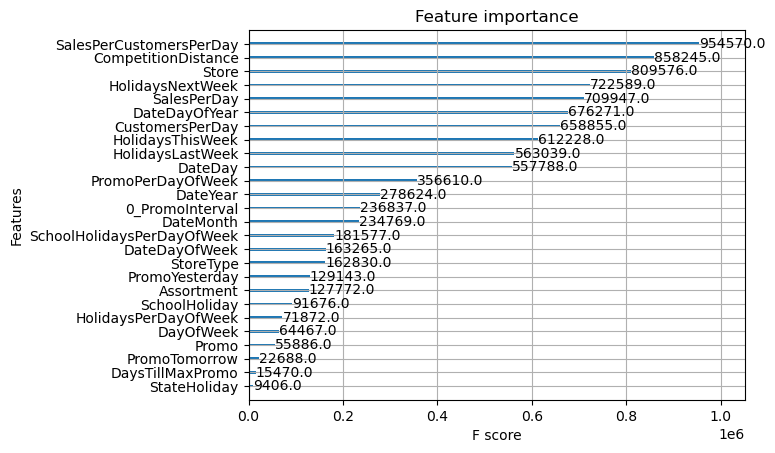

In [191]:
# Print feature importance
plt.figure(figsize = (18, 8))
from xgboost import plot_importance
plot_importance(model)
plt.show()

In [193]:
submit = df.loc[df['is_train'] == 0]
dsubmit = xgb.DMatrix(submit[features_x])
predictions = model.predict(dsubmit)

df_predictions = submit['Id'].reset_index()
df_predictions['Id'] = df_predictions['Id'].astype('int')
df_predictions['Sales'] = (np.exp(predictions) - 1) * 0.985 #Scale Back

df_predictions.sort_values('Id', inplace=True)
df_predictions[['Id', 'Sales']].to_csv('solution.csv', index=False)